# MedCompare

## Requirements

Attention: before running, switch to gpu execution

In [1]:
!pip install datasets
!pip install transformers
!pip install huggingface_hub
!pip install tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from huggingface_hub import notebook_login

In [3]:
notebook_login()

## 1. Data Processing


In [28]:
import re
import json
import requests
import numpy as np
from transformers import AutoTokenizer, pipeline, AutoModel, pipeline
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer


Load Data

In [29]:
dataset = load_dataset("MattBastar/Medicine_Details")
data = dataset['train']
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
vectorizer = TfidfVectorizer(max_features=1000, stop_words=None)


We get the ontology mapping via open source platform BioPortal bioontology. For this u need a file (api-key.txt) that contains an api-key for BioPortal. For this create an account5 at https://bioportal.bioontology.org/ and get your own key.

In [30]:
# Function to clean text

# def clean_text(text):
#     text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
#     text = re.sub(r"\b\d+\b", "", text)  # Remove standalone numbers
#     text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
#     return text

def clean_text(text):
    # Step 1: Remove special characters except for alphanumeric and spaces
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Keep only letters and spaces

    # Step 2: Remove standalone numbers
    text = re.sub(r"\b\d+\b", "", text)

    # Step 3: Remove specific unwanted terms
    unwanted_terms = ["mg", "treatment", "Treatment", "MG", "mg", "ML", "ml", "of", "mgml"]  # Add other terms to this list as needed
    for term in unwanted_terms:
        text = re.sub(rf"\b{term}\b", "", text, flags=re.IGNORECASE)

    # Step 4: Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text



In [31]:
# #BASE_URL = "http://data.bioontology.org"
# #file = open("api-key.txt", "r")
# API_KEY = file.read().strip()
# #file.close()

# headers = {
#     "Authorization": f"apikey token={API_KEY}"
# }

# Function to look up ontology mappings from BioPortal API

# def get_bioportal_mapping(term):

#     params = {
#         "q": term,
#         "require_exact_match": "false" # false or true  deoending on exact matching
#     }
#     response = requests.get(f"{BASE_URL}/search", headers=headers, params=params)

#     if response.status_code != 200:
#         return {term: "unknown"}  # Default to "unknown" if the API call fails

#     data = response.json()

#     # Filter relevant mappings based on ontology prefixes else words without medical context get mapped as well
#     relevant_prefixes = [
#         "http://purl.bioontology.org/ontology",  # BioPortal's main prefix
#         "http://www.co-ode.org/ontologies/galen",  # GALEN ontology
#         "http://ncicb.nci.nih.gov"  # NCI Thesaurus
#     ]

#     for result in data.get("collection", []):
#         label = result.get("prefLabel")
#         ontology_id = result.get("@id")

#         if label and ontology_id and any(ontology_id.startswith(prefix) for prefix in relevant_prefixes):
#             return {label.lower(): ontology_id}

#     # Default
#     return {term: "unknown"}

### Processing User Input


In [32]:
pipe = pipeline("token-classification", model="Clinical-AI-Apollo/Medical-NER", aggregation_strategy="simple")

def preprocess_user_input_with_ner(user_input):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Step 1: Use the NER pipeline to extract medical entities
    ner_results = pipe(user_input)

    # Step 2: Group all entities by their types
    grouped_entities = {}
    for entity in ner_results:
        entity_group = entity["entity_group"]
        if entity_group not in grouped_entities:
            grouped_entities[entity_group] = []
        grouped_entities[entity_group].append(entity["word"])

    # Step 3: Collect all identified words
    all_words = []
    for group, words in grouped_entities.items():
        all_words.extend(words)

    # Step 4: Combine all words into a single string
    combined_text = " ".join(all_words)
    print(f"Combined Text: {combined_text}")

    # Step 5: Generate a single embedding for the combined text
    inputs = tokenizer(combined_text, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        combined_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # CLS token embedding

    # Step 6: Return results
    return {
        "cleaned_input": user_input,
        "ner_results": ner_results,
        "grouped_entities": grouped_entities,
        "all_words": all_words,
        "combined_text": combined_text,
        "combined_embedding": combined_embedding  # Single combined embedding
    }

def preprocess_user_input_with_ner_tfidf(user_input):
    # Step 1: Use the NER pipeline to extract medical entities
    ner_results = pipe(user_input)

    # Step 2: Group all entities by their types
    grouped_entities = {}
    for entity in ner_results:
        entity_group = entity["entity_group"]
        if entity_group not in grouped_entities:
            grouped_entities[entity_group] = []
        grouped_entities[entity_group].append(entity["word"])

    # Step 3: Collect all identified words
    all_words = []
    for group, words in grouped_entities.items():
        all_words.extend(words)

    # Step 4: Combine all words into a single string
    combined_text = " ".join(all_words)
    print(f"Combined Text: {combined_text}")

    tfidf_embeddings = vectorizer.transform([combined_text])

    print(tfidf_embeddings.shape)
    # Step 6: Return results
    return {
        "cleaned_input": user_input,
        "ner_results": ner_results,
        "grouped_entities": grouped_entities,
        "all_words": all_words,
        "combined_text": combined_text,
        "combined_embedding": tfidf_embeddings  # Feature names for interpretation
    }


Device set to use cuda:0


###Preprocessing for User Input aswell as Dataset

In [33]:
def preprocess_with_ner(text_input):
    ner_results = pipe(text_input)
    all_words = [entity["word"] for entity in ner_results]
    combined_text = " ".join(all_words)
    return combined_text

In [34]:
def combine_text(record):
    composition = clean_text(record['Composition'])
    uses = clean_text(record['Uses'])
    return f"{composition}{uses}"


processed_texts = [preprocess_with_ner(combine_text(record)) for record in tqdm(data, desc="Processing records")]



Processing records: 100%|██████████| 11825/11825 [04:54<00:00, 40.18it/s]


In [35]:
import csv

output_file = "processed_texts.csv"

# Save to a CSV file
with open(output_file, "w", encoding="utf-8", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Processed Text"])  # Header row
    for text in processed_texts:
        writer.writerow([text])

print(f"Processed texts saved to {output_file}")
from google.colab import files

# Download the CSV file
files.download(output_file)


Processed texts saved to processed_texts.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Generate and store Dataset embeddings with Clinical-BERT

In [36]:
def generate_embeddings(processed_text, model, tokenizer):
  print("Executing with Cuda GPU: " + str(torch.cuda.is_available()))
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  embeddings = []
  for text in tqdm(processed_text, desc="Generating embeddings"):
      inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
      with torch.no_grad():
          outputs = model(**inputs)
      embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
      embeddings.append(embedding)

  # Convert embeddings to a NumPy array
  entity_embedding = np.array(embeddings)
  return entity_embedding


data_embeddings_bert = generate_embeddings(processed_texts, model, tokenizer)


Executing with Cuda GPU: True


Generating embeddings: 100%|██████████| 11825/11825 [01:40<00:00, 117.81it/s]


In [37]:
embeddings_file = "data_embeddings_bert.npy"
np.save(embeddings_file, data_embeddings_bert)

print(f"BERT Embeddings saved to {embeddings_file}")


BERT Embeddings saved to data_embeddings_bert.npy


### Generate and store Dataset embeddings with TFIDF

In [38]:
def generate_tfidf_embeddings(processed_texts):
    processed_texts = [text for text in processed_texts if text.strip()]

    tfidf_embeddings = vectorizer.fit_transform(processed_texts)

    return tfidf_embeddings


data_embeddings_tfidf = generate_tfidf_embeddings(processed_texts)


In [39]:
embeddings_file = "data_embeddings_tfidf.npy"
np.save(embeddings_file, data_embeddings_tfidf)

print(f"TFIDF Embeddings saved to {embeddings_file}")


TFIDF Embeddings saved to data_embeddings_tfidf.npy


## 2. Similarity Ranking

Prepare Data Embeddings and Query Embeddings for Ranking

TODO: maybe add normalization before embedding

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

function for user query preprocessing

In [41]:
def prepare_query_for_similarity_ranking(query, embedding_type = 'bert'):

  query = clean_text(query)

  if(embedding_type == 'tfidf'):
    preprocessed_query = preprocess_user_input_with_ner_tfidf(query)
  else:
    preprocessed_query = preprocess_user_input_with_ner(query)

  print("NER Results:", preprocessed_query["ner_results"])
  print(f"NER Query for Embedding: {preprocessed_query['combined_text']}")

  query_embedding = preprocessed_query["combined_embedding"]

  # print(group_embedding.shape)
  # print(embedding_type)
  if(embedding_type == 'bert'):
    query_embedding = np.array(query_embedding).reshape(1, -1)

  return query_embedding


function for ranking best Matches and Eliminate Duplicates, because necessary only Substances and Dataset provides multiple solutions with different dosages


In [42]:
def similarity_ranking(similarities, data, top_k = 5):

  medicine_names = [record['Medicine Name'] for record in data]
  compositions = [record['Composition'] for record in data]
  uses= [record['Uses'] for record in data]
  side_effects = [record['Side_effects'] for record in data]
  ratings = [record['Average Review %'] for record in data]


  ranked_indices = np.argsort(similarities[0])[::-1]  # Sort indices by similarity in descending order

  unique_compositions = set()
  final_results = []  # To store the final unique top-k results

  for idx in ranked_indices:
      medicine_name = medicine_names[idx]
      composition = compositions[idx]
      use = uses[idx]
      side_effect = side_effects[idx]
      average_review = ratings[idx]

      # Check for uniqueness based on composition
      if clean_text(composition) not in unique_compositions:
          unique_compositions.add(clean_text(composition)) # Mark composition as seen
          final_results.append({
              "Medicine": medicine_name,
              "Composition": composition,
              "Use": use,
              "Side Effects": side_effect,
              "Similarity": similarities[0][idx]
          })

      if len(final_results) == top_k:
          break
  return final_results

function for printing top results

In [43]:
def print_results(similarity_results):
  print("\nTop matching medications with side effects:")
  for result in similarity_results:
      print(f"Composition: {result['Composition']}, Use: {result['Use']}, \nSide Effects: {result['Side Effects']},\n Similarity: {result['Similarity']:.4f}\n")

  print("\n" + "=" * 50 + "\n")

###Calculating Cosine Similarities with Sklearn
and combine all together

In [53]:
def similarity(query, data_embedding, ground_data, embedding_type = 'bert'):
    query_embedding = prepare_query_for_similarity_ranking(query, embedding_type)
    #cosine similarity sklearn
    similarities = cosine_similarity(query_embedding, data_embedding)
    similarity_results = similarity_ranking(similarities, ground_data)
    print('')
    print(embedding_type)
    print_results(similarity_results)


###Testing of Similarity Ranking

In [72]:
query1 = "The patient is allergic to Mefenamin Acid another pain relief medication."
similarity(query1, data_embeddings_tfidf, data, embedding_type = 'tfidf')
similarity(query1, data_embeddings_bert, data)
print("-------------------------------------------------------------------------")


query2 = "Antibiotics."
similarity(query2, data_embeddings_tfidf, data, embedding_type = 'tfidf')
similarity(query2, data_embeddings_bert, data)
print("-------------------------------------------------------------------------")


query3 = "What are the available medications for a skin inflammation"
similarity(query3, data_embeddings_tfidf, data, embedding_type = 'tfidf')
similarity(query3, data_embeddings_bert, data)
print("-------------------------------------------------------------------------")


query4 = "I have acute migraine need a medication with minimal side effects."
similarity(query4, data_embeddings_tfidf, data, embedding_type = 'tfidf')
similarity(query4, data_embeddings_bert, data)
print("-------------------------------------------------------------------------")


query5 = "What medications are recommended for managing diabetes mellitus"
similarity(query5, data_embeddings_tfidf, data, embedding_type = 'tfidf')
similarity(query5, data_embeddings_bert, data)
print("-------------------------------------------------------------------------")


Combined Text: me fenamin acid pain relief
(1, 1000)
NER Results: [{'entity_group': 'MEDICATION', 'score': 0.2702273, 'word': 'me', 'start': 26, 'end': 29}, {'entity_group': 'DETAILED_DESCRIPTION', 'score': 0.36725488, 'word': 'fenamin acid', 'start': 29, 'end': 41}, {'entity_group': 'DIAGNOSTIC_PROCEDURE', 'score': 0.11181343, 'word': 'pain', 'start': 49, 'end': 54}, {'entity_group': 'DISEASE_DISORDER', 'score': 0.18120886, 'word': 'relief', 'start': 54, 'end': 61}]
NER Query for Embedding: me fenamin acid pain relief

tfidf

Top matching medications with side effects:
Medicine: Hyocimax MF  Tablet,
Composition: Hyoscine butylbromide (10mg) + Mefenamic Acid (250mg), Use: Treatment of Menstrual pain, 
Side Effects: Nausea Vomiting Dryness in mouth Heartburn,
 Similarity: 0.7996

Medicine: Meflotas Tablet,
Composition: Mefloquine (250mg), Use:  Malaria, 
Side Effects: Abdominal pain Abnormal dreams Anxiety Chills Depression Diarrhea Dizziness Fever Headache Atrial arrhythmias altered he

## 3. Evaluation of Clinical-BERT & TFIDF results


Get Query Dictonary with evaluation:
rating_precision -> bool relevant or not
rating_relevance -> output top 5 (1,2,3,4,5) gets a relevant rating like following:
5: Highly relevant (most relevant item to the query).
4: Very relevant (still strongly related to the query).
3: Moderately relevant (somewhat useful for the query).
2: Slightly relevant (not very useful but loosely related).
1: Not relevant (unlikely to satisfy the query).

In [73]:
import pandas as pd

queries = [
    query1,
    query2,
    query3,
    query4,
    query5
]
# TODO: DONE make correct evaluation
ratings = {
    "q1": {
        "precision_tfidf": (0, 0, 0, 1, 1),
        "precision_bert": (1, 1, 1, 0, 1),
        "relevance_tfidf": (2, 1, 2, 5, 5),
        "relevance_bert": (5, 5, 5, 1, 5),
    },
    "q2": {
        "precision_tfidf": (0, 0, 0, 0, 0),
        "precision_bert": (1, 1, 1, 1, 1),
        "relevance_tfidf": (1, 1, 1, 1, 1),
        "relevance_bert": (5, 5, 5, 5, 5),
    },
    "q3": {
        "precision_tfidf": (0, 1, 0, 1, 0),
        "precision_bert": (0, 0, 0, 1, 0),
        "relevance_tfidf": (1, 5, 1, 3, 2),
        "relevance_bert": (2, 0, 2, 2, 1),
    },
    "q4": {
        "precision_tfidf": (0, 0, 0, 0, 1),
        "precision_bert": (1, 1, 1, 0, 1),
        "relevance_tfidf": (1, 1, 1, 2, 3),
        "relevance_bert": (5, 5, 5, 1, 5),
    },
    "q5": {
        "precision_tfidf": (1, 1, 1, 1, 1),
        "precision_bert": (1, 1, 1, 1, 1),
        "relevance_tfidf": (5, 5, 5, 5, 5),
        "relevance_bert": (5, 5, 5, 5, 5),
    }
}

sum_relevant_items = [14, 50, 20, 6, 40]

# Create the big table
evaluation_data = []
for i, query in enumerate(queries, start=1):
    key = f"q{i}"
    evaluation_data.append({
        "query": query,
        "precision_tfidf": ratings[key]["precision_tfidf"],
        "precision_bert": ratings[key]["precision_bert"],
        "relevance_tfidf": ratings[key]["relevance_tfidf"],
        "relevance_bert": ratings[key]["relevance_bert"],
        "sum_relevant_items": sum_relevant_items[i - 1],
    })

df = pd.DataFrame(evaluation_data)

###Precision@K and Recall@K

$
\text{Precision@K} = \frac{\text{Number of relevant items in top-K}}{K}
$


$\text{Recall@K} = \frac{\text{Number of relevant items in top-K}}{\text{Total number of relevant items}}$

$\text{IDCG@K} = \sum_{i=1}^{K} \frac{\text{ideal relevance}_i}{\log_2(i + 1)}$

$\text{NDCG@K} = \frac{\text{DCG@K}}{\text{IDCG@K}}$

In [74]:
def calculate_precision(ratings):
    return sum(ratings) / len(ratings) if len(ratings) > 0 else 0

def calculate_recall(ratings, num_relevant_items):
    return sum(ratings) / num_relevant_items if num_relevant_items > 0 else 0

def calculate_dcg(relevance_scores):
    relevance_scores = np.array(relevance_scores)
    return np.sum((2 ** relevance_scores - 1) / np.log2(np.arange(1, len(relevance_scores) + 1) + 1))

def calculate_ndcg(relevance_scores, ideal_relevance_scores):
    dcg = calculate_dcg(relevance_scores)
    idcg = calculate_dcg(sorted(ideal_relevance_scores, reverse=True))
    return dcg / idcg if idcg > 0 else 0

def compute_metrics(df):
    metrics = []
    for _, row in df.iterrows():
        for embedding_type in ["tfidf", "bert"]:
            # Precision
            precision = calculate_precision(row[f"precision_{embedding_type}"])
            # Recall
            recall = calculate_recall(row[f"precision_{embedding_type}"], row["sum_relevant_items"])
            # NDCG
            relevance_scores = row[f"relevance_{embedding_type}"]
            ideal_relevance_scores = sorted(relevance_scores, reverse=True)
            ndcg = calculate_ndcg(relevance_scores, ideal_relevance_scores)

            # Append metrics
            metrics.append({
                "query": row["query"],
                "embedding_type": embedding_type.upper(),
                "precision": precision,
                "recall": recall,
                "ndcg": ndcg
            })
    return pd.DataFrame(metrics)

# Compute metrics
metrics_df = compute_metrics(df)

# Save metrics to CSV
metrics_df.to_csv("precision_recall_ndcg_metrics.csv", index=False)

print(metrics_df)

                                               query embedding_type  \
0  The patient is allergic to Mefenamin Acid anot...          TFIDF   
1  The patient is allergic to Mefenamin Acid anot...           BERT   
2                                       Antibiotics.          TFIDF   
3                                       Antibiotics.           BERT   
4  What are the available medications for a skin ...          TFIDF   
5  What are the available medications for a skin ...           BERT   
6  I have acute migraine need a medication with m...          TFIDF   
7  I have acute migraine need a medication with m...           BERT   
8  What medications are recommended for managing ...          TFIDF   
9  What medications are recommended for managing ...           BERT   

   precision    recall      ndcg  
0        0.4  0.142857  0.567094  
1        0.8  0.285714  0.983524  
2        0.0  0.000000  1.000000  
3        1.0  0.100000  1.000000  
4        0.4  0.100000  0.668736  
5       

###Compare Models
Precision and Recall Bar Chart

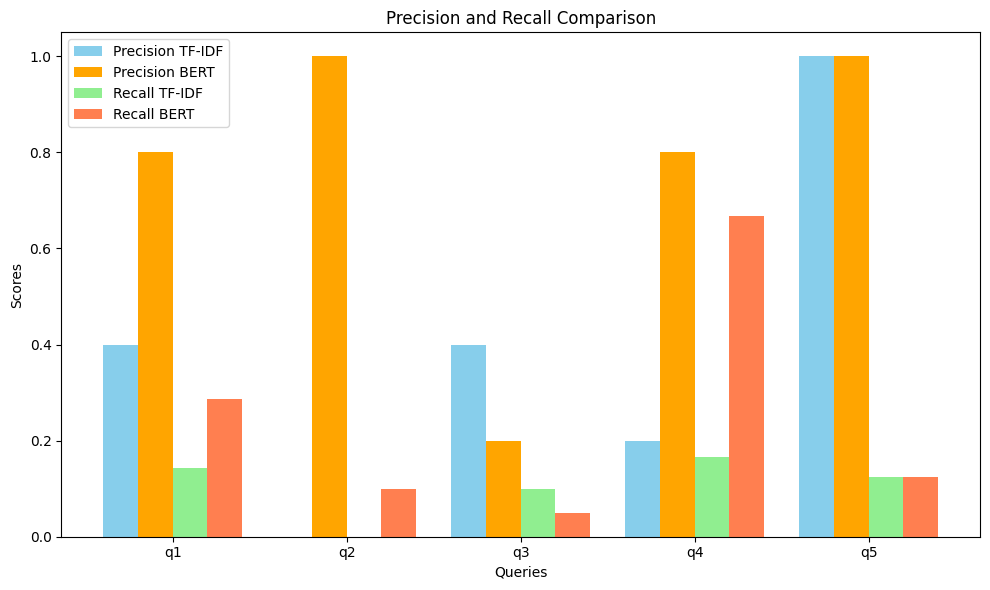

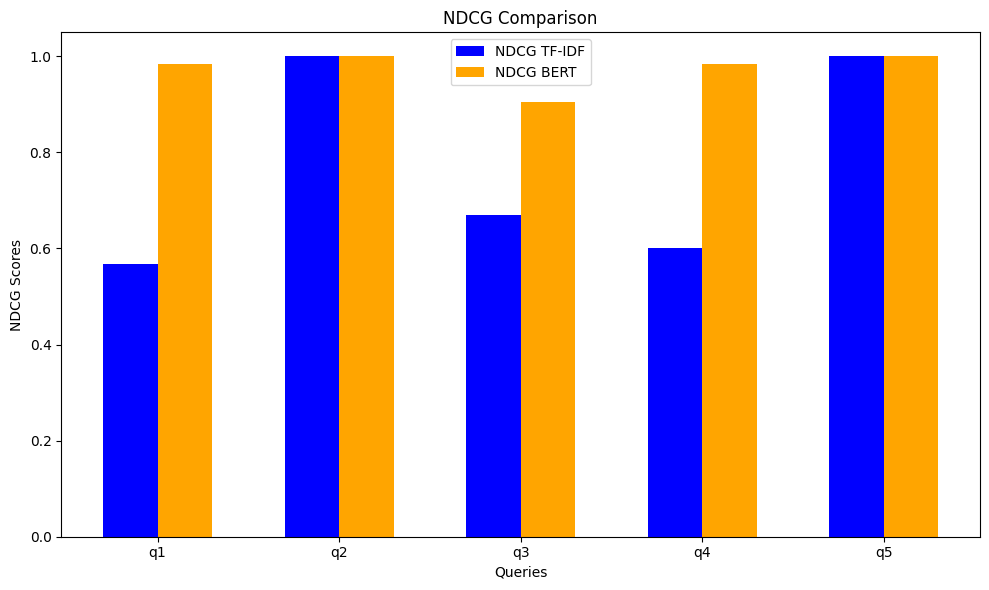

In [75]:
import matplotlib.pyplot as plt
import numpy as np

def plot_precision_recall(metrics_df):

    queries = metrics_df['query_label'].unique()
    x = np.arange(len(queries))  # Label locations

    # Extract precision, recall for TF-IDF and BERT
    precision_tfidf = metrics_df[metrics_df['embedding_type'] == 'TFIDF']['precision'].values
    recall_tfidf = metrics_df[metrics_df['embedding_type'] == 'TFIDF']['recall'].values
    precision_bert = metrics_df[metrics_df['embedding_type'] == 'BERT']['precision'].values
    recall_bert = metrics_df[metrics_df['embedding_type'] == 'BERT']['recall'].values

    # Plot Precision and Recall
    width = 0.2  # Bar width

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width, precision_tfidf, width, label='Precision TF-IDF', color='skyblue')
    ax.bar(x, precision_bert, width, label='Precision BERT', color='orange')
    ax.bar(x + width, recall_tfidf, width, label='Recall TF-IDF', color='lightgreen')
    ax.bar(x + 2 * width, recall_bert, width, label='Recall BERT', color='coral')

    # Formatting
    ax.set_xlabel('Queries')
    ax.set_ylabel('Scores')
    ax.set_title('Precision and Recall Comparison')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(queries)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_ndcg(metrics_df):

    queries = metrics_df['query_label'].unique()
    x = np.arange(len(queries))  # Label locations

    ndcg_tfidf = metrics_df[metrics_df['embedding_type'] == 'TFIDF']['ndcg'].values
    ndcg_bert = metrics_df[metrics_df['embedding_type'] == 'BERT']['ndcg'].values

    # Plot NDCG
    width = 0.3  # Bar width

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width / 2, ndcg_tfidf, width, label='NDCG TF-IDF', color='blue')
    ax.bar(x + width / 2, ndcg_bert, width, label='NDCG BERT', color='orange')

    # Formatting
    ax.set_xlabel('Queries')
    ax.set_ylabel('NDCG Scores')
    ax.set_title('NDCG Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(queries)
    ax.legend()
    plt.tight_layout()
    plt.show()

metrics_df['query_label'] = ['q1', 'q1', 'q2', 'q2', 'q3', 'q3', 'q4', 'q4', 'q5', 'q5']
plot_precision_recall(metrics_df)
plot_ndcg(metrics_df)

